In [12]:
import numpy as np
import torch
from torchvision import transforms
import torch.utils.data as data
import matplotlib.pyplot as plt
import random
import nltk

from data_loader import *
import cv2
from utils import *
from models import *
# Watch for any changes in vocabulary.py, data_loader.py or model.py, and re-load it automatically.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

img_path = '../data/flickr30k-images'
ann_path = '../data/results_20130124.token'

# Display mode (disp_mode) can be the following:
# imgcapretrieval : One image and all captions. Find the top-5 captions for 1 image.
# capimageretrieval : One caption and all images. Find top-5 images for 1 caption.
# allretrieval : Use all images and all captions to calculate recall scores.
dataset = Flickr30kData(img_root=img_path,
                       ann_file=ann_path,
                       transform=transform,
                       fetch_mode='default',
                       mode="test",
                       disp_mode="allretrieval",
                       num_test=1)

In [14]:
def load_model(model_path='npairs_loss_model.tar',map_location='cpu'):
    image_model = VGG19(pretrained=True)
    caption_model = LSTMBranch()
    checkpoint = torch.load(model_path, map_location)
    start_epoch = checkpoint['epoch']
    best_loss = checkpoint['best_loss']
    image_model.load_state_dict(checkpoint['image_model'])
    caption_model.load_state_dict(checkpoint['caption_model'])
    print ("Loaded checkpoint '{}' (epoch {})".format(model_path,checkpoint['epoch']))
    return image_model, caption_model

def gen_matchmap(image_model, caption_model, image_tensor, caption_tensor):
    image_op = image_model(image_tensor)
    caption_op = caption_model(caption_tensor)

    n_imgs = image_op.size(0)
    matchmap_list = []

    for i in range(n_imgs):
        matchmap = matchmap_generate(image_op[i],caption_op[i])
        mm = matchmap.detach().numpy()
        matchmap_list.append(mm)

    return matchmap_list

def get_output(image_tensor,image_model,caption_glove_tensor,caption_model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image_model = image_model.to(device)
    caption_model = caption_model.to(device)
    image_model.eval()
    caption_model.eval()
    image_ip_val = image_tensor.to(device)
    all_caption_output_val=[]
    caption_glove_ip_val = caption_glove_tensor.to(device)
    caption_output_val = caption_model(caption_glove_ip_val)
    image_output_val = image_model(image_ip_val)
    print ("Sanity Check ---> Size of the output tensor from LSTM ",caption_output_val.shape)
    print ("Sanity Check ---> Size of the output tensor from Image Model ",image_output_val.shape)
    return image_output_val, caption_output_val

def get_sim_mat(image_output,caption_glove_tensor_output,score_type):
    sim_mat=[]
    for captiontensor in caption_glove_tensor_output:
        captiontensor = torch.unsqueeze(captiontensor,dim=0)
        sim_val = compute_matchmap_similarity_matrix(image_output,captiontensor,score_type)
        sim_mat.append(sim_val)
    return sim_mat

In [15]:
def get_data(batch_size):
    data_loader = data.DataLoader(dataset=dataset,
                                  batch_size=1,
                                  shuffle=True)

    dataloader_iterator = iter(data_loader)

    for i in range(len(dataset)):
        img, caption_gloves, caption, groundtruth,imageids,annotationsall = next(dataloader_iterator)
        break
    return img,caption_gloves,caption,groundtruth,imageids,annotationsall

In [16]:
image_model, caption_model = load_model()
batch_size = 64
score_type = 'Avg_Both'
image_tensor,caption_glove_list,captions,ground_truth_captions,allimageids,annotationsall = get_data(1)

new_caption_glove = torch.squeeze(caption_glove_list,dim=0)
new_image_tensor=torch.squeeze(image_tensor,dim=0)

image_output, caption_glove_tensor_output = get_output(new_image_tensor,image_model,new_caption_glove,caption_model)

recall_values=calc_recalls_uneven(image_output,caption_glove_tensor_output,score_type)

Loaded checkpoint 'npairs_loss_model.tar' (epoch 34)
Sanity Check ---> Size of the output tensor from LSTM  torch.Size([4556, 22, 1024])
Sanity Check ---> Size of the output tensor from Image Model  torch.Size([25, 1024, 14, 14])


In [17]:
print ("**********************************")
print ("The Recall Scores are:")
print (recall_values)
print ("**********************************")

**********************************
The Recall Scores are:
{'C_r1': 0.0, 'C_r5': 0.0, 'C_r10': 0.0, 'I_r1': 0.0, 'I_r5': 0.16, 'I_r10': 0.48}
**********************************


In [18]:
sim_mat = compute_matchmap_similarity_matrix(image_output,caption_glove_tensor_output,score_type)
num_k=5
C2I_scores, C2I_ind = sim_mat.topk(5,0)
I2C_scores, I2C_ind = sim_mat.topk(5,1)

Image to Caption Visualization
**************************************************
The Ground Truth Captions are:
1 :  A little girl with brown hair is blowing the petals off of a flower .
2 :  A small girl in a dress blows bubbles in a grassy field .
3 :  A little girl is blowing bubbles in a field .
4 :  A little girl blowing bubbles .
**************************************************
**************************************************
The predicted captions are:
1 :  A blond-haired mother is holding her newborn baby .
2 :  A blond girl covering her eyes with her hand in yellow dress .
3 :  Blond girl receiving pink flowers from family after her graduation ceremony .
4 :  A mother holds her newborn baby .
5 :  Girl in pink sweater , playing with a doll .
**************************************************


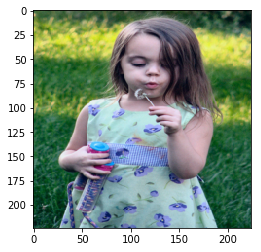

In [28]:
# Image to Caption Visualization
image_id=10
cur_image_tensor=new_image_tensor[image_id]
cur_ground_truth_captions=ground_truth_captions[image_id]

img = torch.squeeze(cur_image_tensor,0)
img = img.permute(1,2,0)
color_img = img.numpy()
color_img = (color_img - np.amin(color_img)) / np.ptp(color_img)
plt.imshow(color_img)

imgtocaptionindices=I2C_ind[image_id]

print ("Image to Caption Visualization")
print ("**************************************************")
print ("The Ground Truth Captions are:")
k=1
for gtcaption in cur_ground_truth_captions:
    print (k,": ",gtcaption[0])
    k=k+1
print ("**************************************************")

print ("**************************************************")
k=1
print ("The predicted captions are:")
for captid in imgtocaptionindices:
    print (k,": ",captions[captid][0])
    k=k+1
print ("**************************************************")

**********************************
The caption of Interest is:
A man wearing a white shirt is talking to a woman wearing a green blouse on the street
**********************************
The Retrieved Images are:
**********************************


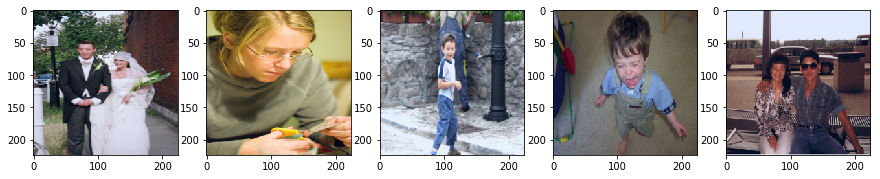

**********************************


'\ncur_ground_truth_captions=ground_truth_captions[image_id]\n\nimg = torch.squeeze(cur_image_tensor,0)\nimg = img.permute(1,2,0)\ncolor_img = img.numpy()\ncolor_img = (color_img - np.amin(color_img)) / np.ptp(color_img)\nplt.imshow(color_img)\n\nimgtocaptionindices=I2C_ind[image_id]\n\nprint ("Image to Caption Visualization")\nprint ("**************************************************")\nprint ("The Ground Truth Captions are:")\nk=1\nfor gtcaption in cur_ground_truth_captions:\n    print (k,": ",gtcaption[0])\n    k=k+1\nprint ("**************************************************")\n\nprint ("**************************************************")\nk=1\nprint ("The predicted captions are:")\nfor captid in imgtocaptionindices:\n    print (k,": ",captions[captid][0])\n    k=k+1\nprint ("**************************************************")\n'

In [11]:
# Caption to Image Visualization
caption_id=3500
captiontoimageindices=C2I_ind[:,caption_id]

print ("**********************************")
print ("The caption of Interest is:")
print (captions[caption_id][0])
print ("**********************************")


print ("The Retrieved Images are:")
print ("**********************************")
plt.figure(figsize=(15,15))
for i in range(len(captiontoimageindices)):
    subplotid="15"+str(i+1)
    cur_image_tensor=new_image_tensor[captiontoimageindices[i]]
    img = torch.squeeze(cur_image_tensor,0)
    img = img.permute(1,2,0)
    color_img = img.numpy()
    color_img = (color_img - np.amin(color_img)) / np.ptp(color_img)
    plt.subplot(int(subplotid))
    plt.imshow(color_img)
plt.show()
print ("**********************************")


#print ("The Ground Truth Image is:")
#print ("**********************************")
#plt.figure(figsize=(15,15))
#gt_image_id=
#    subplotid="15"+str(i+1)
#    cur_image_tensor=new_image_tensor[captiontoimageindices[i]]
#    img = torch.squeeze(cur_image_tensor,0)
#    img = img.permute(1,2,0)
#    color_img = img.numpy()
#    color_img = (color_img - np.amin(color_img)) / np.ptp(color_img)
#    plt.subplot(int(subplotid))
#    plt.imshow(color_img)
#plt.show()
#print ("**********************************")

'''
cur_ground_truth_captions=ground_truth_captions[image_id]

img = torch.squeeze(cur_image_tensor,0)
img = img.permute(1,2,0)
color_img = img.numpy()
color_img = (color_img - np.amin(color_img)) / np.ptp(color_img)
plt.imshow(color_img)

imgtocaptionindices=I2C_ind[image_id]

print ("Image to Caption Visualization")
print ("**************************************************")
print ("The Ground Truth Captions are:")
k=1
for gtcaption in cur_ground_truth_captions:
    print (k,": ",gtcaption[0])
    k=k+1
print ("**************************************************")

print ("**************************************************")
k=1
print ("The predicted captions are:")
for captid in imgtocaptionindices:
    print (k,": ",captions[captid][0])
    k=k+1
print ("**************************************************")
'''

In [6]:
annotationsall

{'1011572216.jpg': [('bride and groom walking side by side out of focus on pathway next to brick building .',),
  ('A beautiful bride walking on a sidewalk with her new husband .',),
  ('A recently married couple pose for the camera .',),
  ('A groom and bride are standing arm in arm .',),
  ('A couple getting married .',)],
 '1012150929.jpg': [("A little boy plays with a Nintendo GameCube controller inside a McDonald 's .",),
  ("A young boy plays a video game in a McDonald 's restaurant .",),
  ("A young boy plays with a GameCube kiosk at McDonald 's .",),
  ("A little boy playing GameCube at a McDonald 's .",),
  ("A little kid playing GameCube at McDonald 's .",)],
 '101262930.jpg': [('A man in sunglasses puts his arm around a woman in a black and white blouse .',),
  ('A man in sunglasses puts his arm around a woman .',),
  ('A man and woman pose in front of some traffic .',),
  ('An Asian couple sitting on the bench .',)],
 '1015118661.jpg': [('Smiling boy in white shirt and blue

In [7]:
for i,cap in :
    print(annotationsall)

KeyError: 0

In [ ]:
len(vis_img_list)